In [1]:
from utils.streamline_to_surface_utils import *
from utils.surface_label_utils import *
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
subjects_dir = "/home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer"
subjects_list = ["subj01", "subj02", "subj03", "subj04", "subj05", "subj06", "subj07", "subj08"]
#subjects_list = ["subj01", "subj02"]
hemis = ["lh", "rh"]
runs = ["run1", "run2"]
floc_words_labels = {1: "OWFA", 2: "VWFA1", 3: "VWFA2"}

In [3]:
lhOWFAtoIPS0or1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
lhOWFAtoIPS0 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
lhOWFAtoIPS1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])

lhVWFA1toIPS0or1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
lhVWFA1toIPS0 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
lhVWFA1toIPS1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])

lhVWFA2toIPS0or1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
lhVWFA2toIPS0 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
lhVWFA2toIPS1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])

rhOWFAtoIPS0or1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
rhOWFAtoIPS0 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
rhOWFAtoIPS1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])

rhVWFA1toIPS0or1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
rhVWFA1toIPS0 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
rhVWFA1toIPS1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])

rhVWFA2toIPS0or1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
rhVWFA2toIPS0 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
rhVWFA2toIPS1 = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])

In [4]:
# Function to set values greater than 6 to 6
def cap_at_six(x):
    return min(x, 6)

# 1 table for each VTC ROI: FFA1 to IPS0/1; FFA2 to IPS0/1; OFA to IPS0/1
for subj in subjects_list:
    subj_dir = op.join(subjects_dir, subj)
    for hemi in hemis:
        for run in runs:
            floc_words_path = op.join(subj_dir, "fyz", "anatomy", f"{hemi}-rois", "all", "floc-words", f"{hemi}.floc-words.subsetted.mgz")
            available_ROIs, available_ROINums = available_floc_rois(floc_words_path)
            for start in available_ROINums:   
                prf_label = op.join(subjects_dir, subj, "label", hemi + ".prfeccentricity.smoothed.mgz") # non smoothed is just without .smoothed

                endpoints_to_IPS0 = op.join(subjects_dir, subj, "fyz", run, hemi, "floc-words", 
                                            f"node{int(start)}-18.endpoints.cleaned_withManualIPS.mgz") # could also be .IPS-intersected.mgz
                endpoints_to_IPS1 = op.join(subjects_dir, subj, "fyz", run, hemi, "floc-words", 
                                            f"node{int(start)}-19.endpoints.cleaned_withManualIPS.mgz") # could also be .IPS-intersected.mgz
                
                concat_surflabels(endpoints_to_IPS0, endpoints_to_IPS1, write_file=True, 
                                  out_path=op.join(subjects_dir, subj, "fyz", run, hemi, "floc-words"), 
                                  change_label="withIPS1")
                endpoints_to_IPS0or1 = op.join(subjects_dir, subj, "fyz", run, hemi, "floc-words", 
                                        f"node{int(start)}-18.endpoints.cleaned_withManualIPS.withIPS1.mgz")
                
                startToIPS0or1, startToIPS0or1Count = label_endpoints_with_pRF_property(prf_label, endpoints_to_IPS0or1)
                startToIPS0, startToIPS0Count = label_endpoints_with_pRF_property(prf_label, endpoints_to_IPS0)
                startToIPS1, startToIPS1Count = label_endpoints_with_pRF_property(prf_label, endpoints_to_IPS1)

                for items in [[startToIPS0or1, startToIPS0or1Count, "IPS0or1"], [startToIPS0, startToIPS0Count, "IPS0"], [startToIPS1, startToIPS1Count, "IPS1"]]:
                    propStreamlinesSubj = f"propStreamlines{subj}{run}"
                    df = pd.DataFrame(items[0], columns=["Eccentricity", propStreamlinesSubj])
                    
                    dfwithEndpoints = df[df[propStreamlinesSubj] > 0]
                    #dfReasonable = dfwithEndpoints[dfwithEndpoints["Eccentricity"] < 6.25] # 6.25 because rounding to nearest 0.5, based on limitation of stimulus size in experiment
                    dfReasonable = dfwithEndpoints.applymap(cap_at_six)
                    #dfReasonable = (dfReasonable*2).round()/2 # rounding to neatest 0.5
                    dfReasonable = dfReasonable.round(0)
                    dfReasonable = dfReasonable.groupby("Eccentricity").sum().reset_index()
                    dfReasonable[propStreamlinesSubj] = dfReasonable[propStreamlinesSubj] / items[1] # puts everything into proportions
                    
                    # Selectively merge with correct dataframe
                    vars()[f"{hemi}{floc_words_labels[int(start)]}to{items[2]}"] = vars()[f"{hemi}{floc_words_labels[int(start)]}to{items[2]}"].merge(dfReasonable, on="Eccentricity", how="outer")
                    

Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run1/lh/floc-words/node1-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run1/lh/floc-words/node2-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run1/lh/floc-words/node3-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run2/lh/floc-words/node1-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run2/lh/floc-words/node2-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run2/lh/floc-words/node3-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01

Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj05/fyz/run2/rh/floc-words/node2-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj05/fyz/run2/rh/floc-words/node3-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj06/fyz/run1/lh/floc-words/node1-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj06/fyz/run1/lh/floc-words/node2-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj06/fyz/run1/lh/floc-words/node3-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj06/fyz/run2/lh/floc-words/node1-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj06

<Figure size 640x480 with 0 Axes>

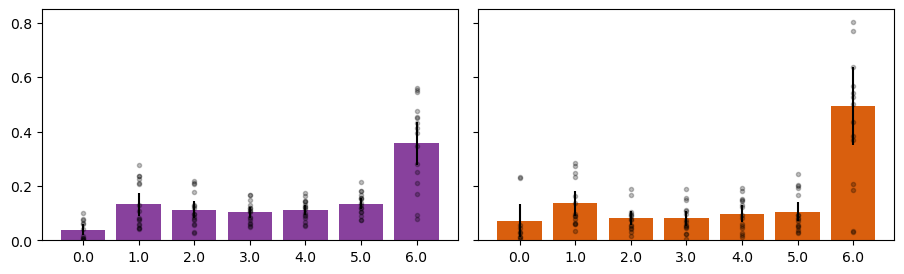

In [15]:
df = lhOWFAtoIPS0
transpose = df.transpose()
transpose = transpose.rename(columns=transpose.iloc[0])[1:]

a = transpose.describe()
means = a.loc['mean'].values.tolist()
stdevs = a.loc['std'].values.tolist()
counts = a.loc['count'].values.tolist()
index = np.arange(len(transpose.columns))

CI = []
for i in range(len(means)):
    CIval = 1.96*stdevs[i]/(counts[i]**(0.5)) # we might want to use the proportion CI calculation instead of means
    CI.append(CIval)
    
plt.figure()
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(11, 3))
ax1.set_xticks(index)
ax1.set_xticklabels(transpose.columns)
ax1.set_ylim(0, 0.85)

ax1.bar(index, means, yerr=CI, color="#88419d")
#ax1.tight_layout()
ax1.scatter(transpose.melt()["variable"], transpose.melt()["value"], marker=".", alpha=0.25, color="black")



df = rhOWFAtoIPS0
transpose = df.transpose()
transpose = transpose.rename(columns=transpose.iloc[0])[1:]
#transpose = transpose.drop(["propStreamlinessubj07run1", "propStreamlinessubj07run2"])
a = transpose.describe()
means = a.loc['mean'].values.tolist()
stdevs = a.loc['std'].values.tolist()
counts = a.loc['count'].values.tolist()
index = np.arange(len(transpose.columns))

CI = []
for i in range(len(means)):
    CIval = 1.96*stdevs[i]/(counts[i]**(0.5)) # we might want to use the proportion CI calculation instead of means
    CI.append(CIval)

ax2.set_xticks(index)
ax2.set_xticklabels(transpose.columns)
ax2.set_ylim(0, 0.85)
ax2.yaxis.set_ticklabels([])

ax2.bar(index, means, yerr=CI, color="#d95f0e")
#ax1.tight_layout()
ax2.scatter(transpose.melt()["variable"], transpose.melt()["value"], marker=".", alpha=0.25, color="black")

plt.subplots_adjust(wspace=0.05, hspace=0)

plt.savefig("/home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/figures/rhFFA2toIPS0andEVC.svg")
